In [4]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

In [5]:
monet_path = '/kaggle/input/gan-getting-started/monet_jpg/'
photo_path = '/kaggle/input/gan-getting-started/photo_jpg/'

In [6]:
transform = transforms.Compose([
    transforms.Resize((256,256)),transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])

In [7]:
class MonetDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_files = [os.path.join(monet_dir, f) for f in os.listdir(monet_dir)]
        self.photo_files = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]
        self.transform = transform

    def __len__(self):
        return min(len(self.monet_files), len(self.photo_files))  # Match dataset size

    def __getitem__(self, idx):
        monet_img = Image.open(self.monet_files[idx]).convert("RGB")
        photo_img = Image.open(self.photo_files[idx]).convert("RGB")

        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)

        return monet_img, photo_img
        

In [8]:
#Load the data
dataset = MonetDataset(monet_path, photo_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

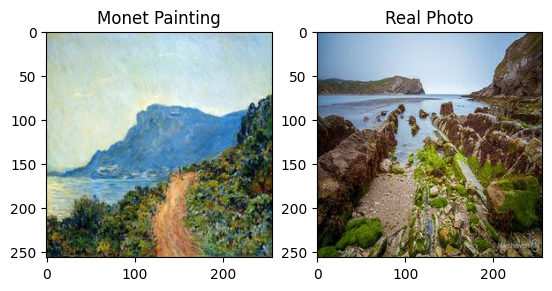

In [9]:
#Let's visualize the data
import matplotlib.pyplot as plt
sample_monet, sample_photo = next(iter(dataloader))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample_monet.squeeze().permute(1, 2, 0) * 0.5 + 0.5)
ax[0].set_title("Monet Painting")
ax[1].imshow(sample_photo.squeeze().permute(1, 2, 0) * 0.5 + 0.5)
ax[1].set_title("Real Photo")
plt.show()

Generator class implementation (U-Net based)

In [14]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),

            # ResNet Blocks
            *[ResBlock(256) for _ in range(6)],

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

generator_A2B = Generator()  # Photo -> Monet

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

discriminator_A = Discriminator()  # Monet Discriminator

In [19]:
def show_generated_samples(generator, real_photo, epoch):
    generator.eval() #Set the generator to evaluation mode
    with torch.no_grad():
        fake_monet = generator(real_photo.to(device)).cpu()
    #Convert tensors to displayable images
    real_photo = real_photo.squeeze().permute(1, 2, 0)*0.5 + 0.5
    fake_monet = fake_monet.squeeze().permute(1, 2, 0)*0.5 + 0.5

    #plot real & fake images
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(real_photo.numpy())
    ax[0].set_title("Real Photo")
    ax[0].axis("off")

    ax[1].imshow(fake_monet.numpy())
    ax[1].set_title("Generated Monet Painting")
    ax[1].axis("off")

    plt.show()

Epoch [5/100]: 100%|██████████| 300/300 [00:37<00:00,  7.99it/s, D_loss=0.103, G_loss=2.89]  


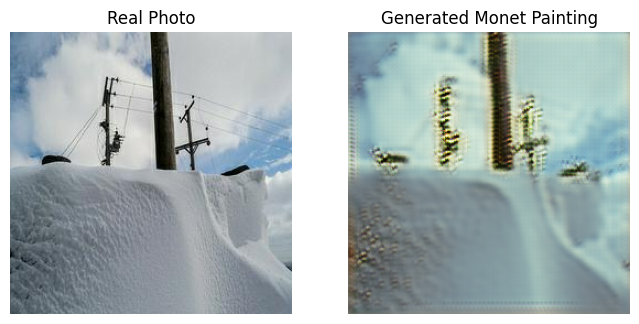

Epoch [10/100]: 100%|██████████| 300/300 [00:37<00:00,  7.99it/s, D_loss=0.252, G_loss=1.65] 


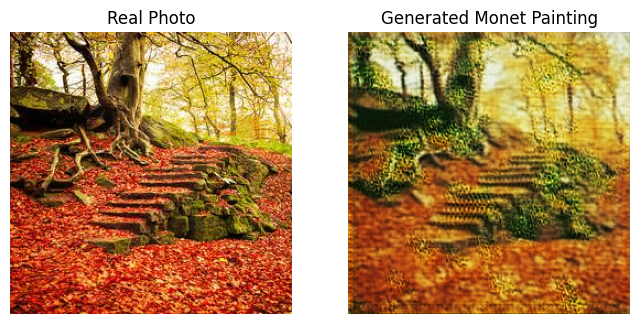

Epoch [15/100]: 100%|██████████| 300/300 [00:37<00:00,  7.99it/s, D_loss=0.23, G_loss=1.55]  


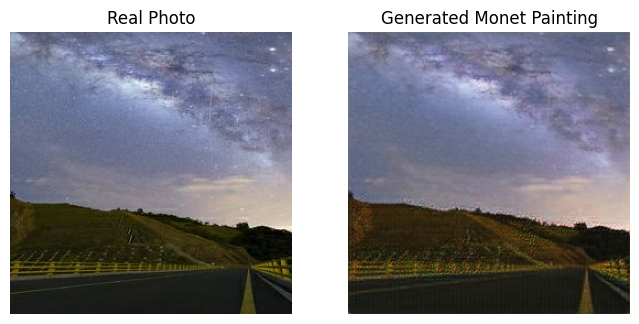

Epoch [20/100]: 100%|██████████| 300/300 [00:37<00:00,  7.99it/s, D_loss=0.106, G_loss=1.42]  


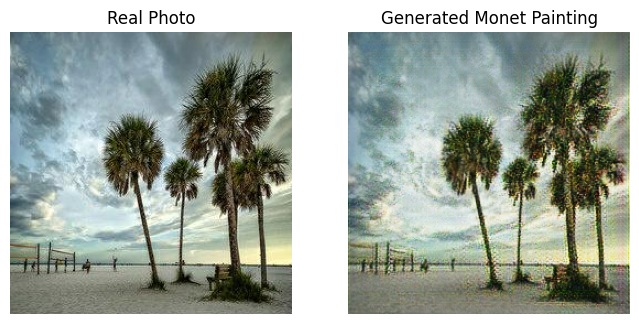

Epoch [25/100]: 100%|██████████| 300/300 [00:37<00:00,  7.97it/s, D_loss=0.0222, G_loss=1.86] 


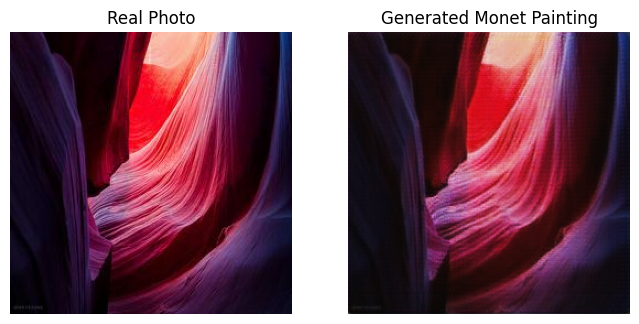

Epoch [30/100]: 100%|██████████| 300/300 [00:37<00:00,  7.98it/s, D_loss=0.15, G_loss=1.52]  


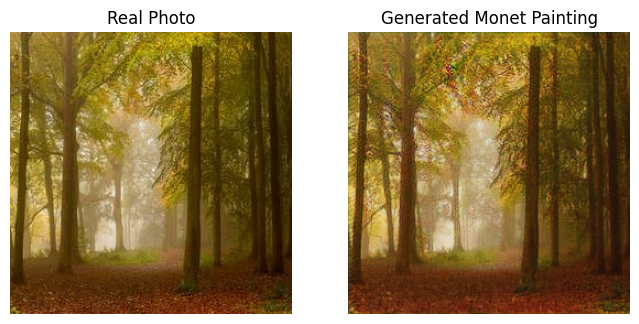

Epoch [35/100]: 100%|██████████| 300/300 [00:37<00:00,  8.00it/s, D_loss=0.142, G_loss=1.39] 


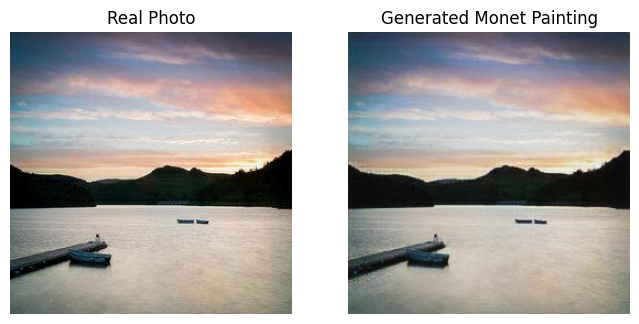

Epoch [40/100]: 100%|██████████| 300/300 [00:37<00:00,  8.07it/s, D_loss=0.149, G_loss=1.77] 


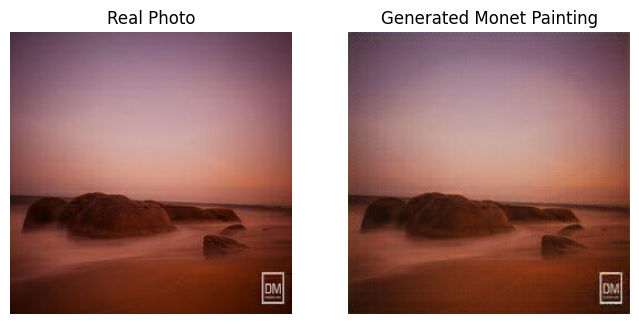

Epoch [45/100]: 100%|██████████| 300/300 [00:37<00:00,  8.07it/s, D_loss=0.191, G_loss=0.753]


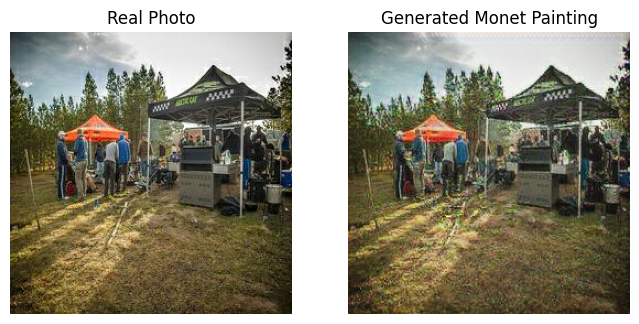

Epoch [50/100]: 100%|██████████| 300/300 [00:37<00:00,  8.05it/s, D_loss=0.162, G_loss=1.6]  


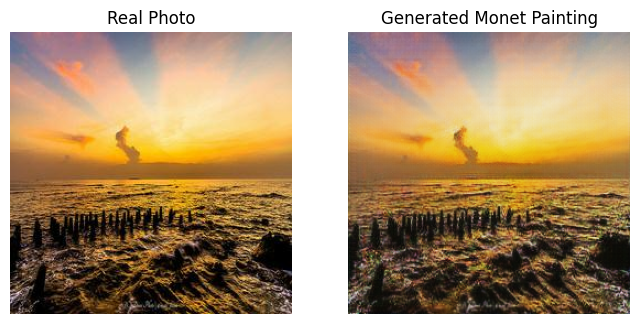

Epoch [55/100]: 100%|██████████| 300/300 [00:37<00:00,  8.06it/s, D_loss=0.143, G_loss=1.62] 


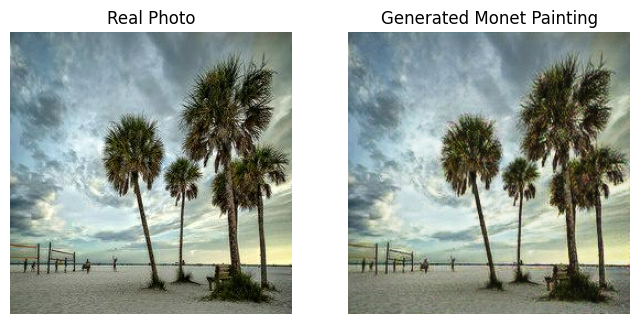

Epoch [60/100]: 100%|██████████| 300/300 [00:37<00:00,  8.06it/s, D_loss=0.129, G_loss=1.05] 


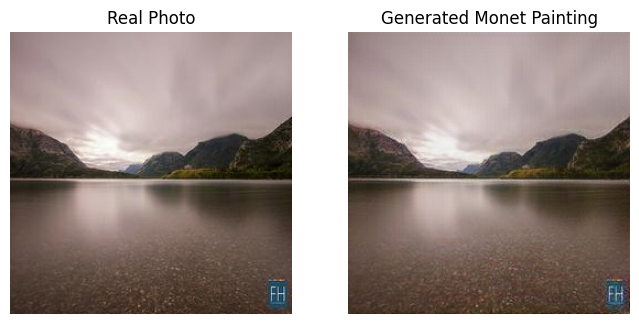

Epoch [65/100]: 100%|██████████| 300/300 [00:37<00:00,  8.07it/s, D_loss=0.0568, G_loss=1.62]


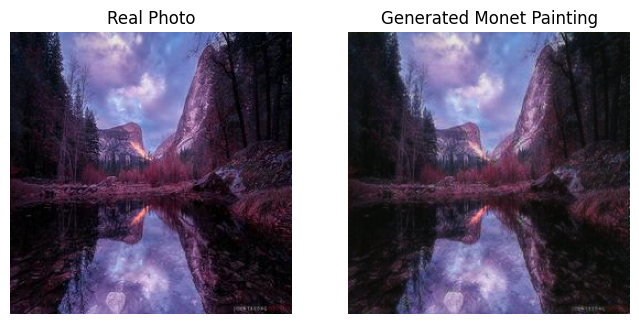

Epoch [70/100]: 100%|██████████| 300/300 [00:37<00:00,  8.03it/s, D_loss=0.105, G_loss=1.42] 


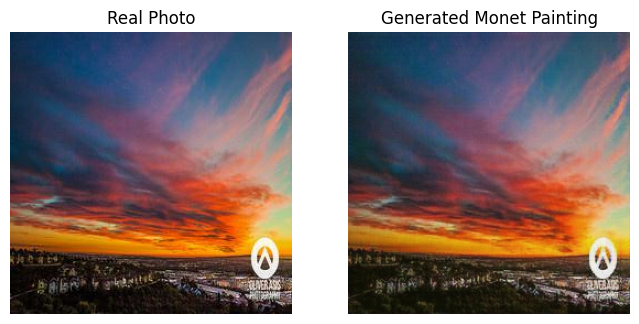

Epoch [75/100]: 100%|██████████| 300/300 [00:37<00:00,  8.01it/s, D_loss=0.17, G_loss=0.812]  


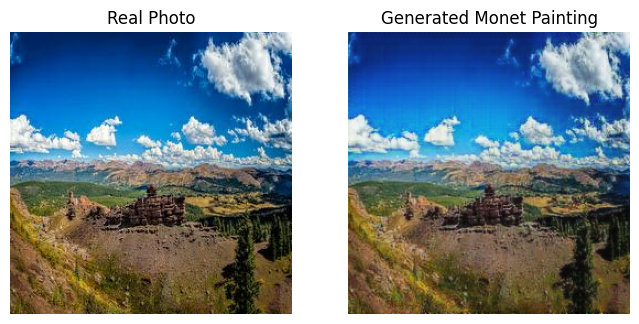

Epoch [80/100]: 100%|██████████| 300/300 [00:37<00:00,  8.02it/s, D_loss=0.0457, G_loss=1.36]


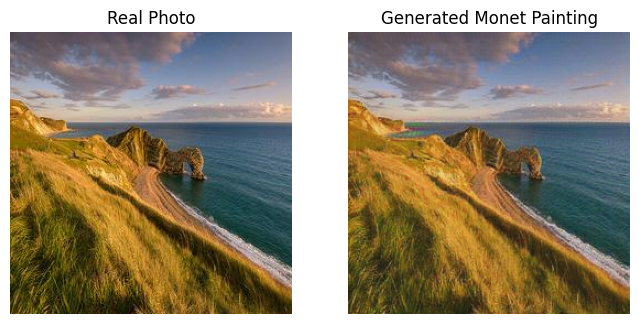

Epoch [85/100]: 100%|██████████| 300/300 [00:37<00:00,  8.05it/s, D_loss=0.218, G_loss=0.853]


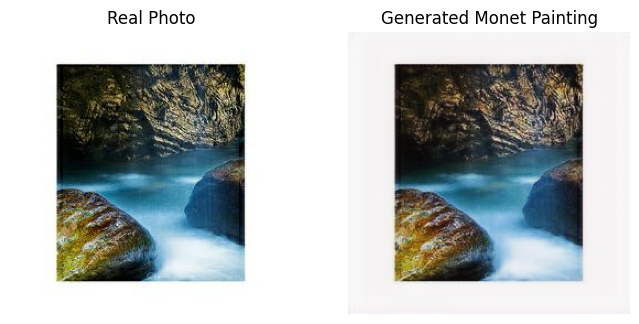

Epoch [90/100]: 100%|██████████| 300/300 [00:37<00:00,  8.04it/s, D_loss=0.0762, G_loss=1.18]


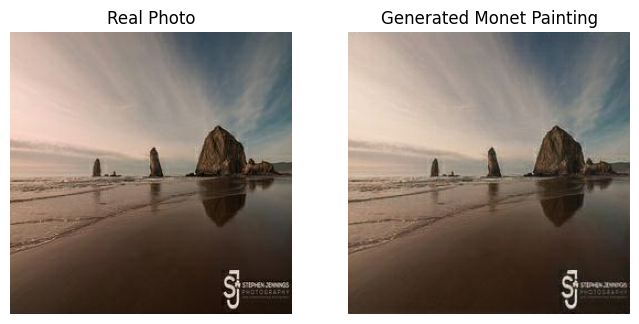

Epoch [95/100]: 100%|██████████| 300/300 [00:37<00:00,  8.04it/s, D_loss=0.204, G_loss=1.44]  


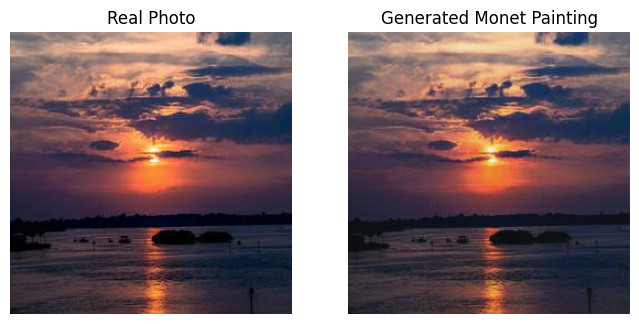

Epoch [97/100]:  11%|█         | 32/300 [00:04<00:33,  8.03it/s, D_loss=0.188, G_loss=1.08] 

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

# Device setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Generator (Photo → Monet) and Discriminator (Monet)
G_A2B = Generator().to(device)  # Photo → Monet
D_B = Discriminator().to(device)  # Monet Discriminator

# Loss functions
criterion_GAN = nn.MSELoss()  # Adversarial loss
criterion_cycle = nn.L1Loss()  # Cycle consistency loss
criterion_identity = nn.L1Loss()  # Identity loss

# Optimizers
optimizer_G = optim.Adam(G_A2B.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
EPOCHS = 100
LAMBDA_CYCLE = 10  # Weight for cycle consistency loss
LAMBDA_IDENTITY = 5  # Weight for identity loss

# Training Loop
for epoch in range(EPOCHS):
    loop = tqdm(dataloader, leave=True)
    
    for i, (real_A, _) in enumerate(loop):  # Only use photos, ignore Monet images
        real_A = real_A.to(device)  # Real photo
        real_B = real_A.clone().to(device)  # Fake Monet (used for identity loss)

        ### ---- TRAIN GENERATOR (Photo → Monet) ---- ###
        optimizer_G.zero_grad()

        fake_B = G_A2B(real_A)  # Generate Monet-style painting
        pred_fake_B = D_B(fake_B)  # Discriminator result on fake Monet

        # Adversarial Loss (Generator should fool Discriminator)
        loss_GAN_A2B = criterion_GAN(pred_fake_B, torch.ones_like(pred_fake_B))

        # Cycle Consistency Loss (Photo → Monet → Photo)
        #rec_A = G_A2B(fake_B)  # Reconstruct photo from fake Monet
        #loss_cycle_A = criterion_cycle(real_A, rec_A) * LAMBDA_CYCLE

        # Identity Loss (Monet → Monet should remain unchanged)
        identity_B = G_A2B(real_B)
        loss_identity_B = criterion_identity(real_B, identity_B) * LAMBDA_IDENTITY

        # Total Generator Loss
        loss_G = loss_GAN_A2B + loss_identity_B
        loss_G.backward()
        optimizer_G.step()

        ### ---- TRAIN DISCRIMINATOR (Monet) ---- ###
        optimizer_D_B.zero_grad()

        # Discriminator Loss: Real Monet
        pred_real_B = D_B(real_B)
        loss_D_real = criterion_GAN(pred_real_B, torch.ones_like(pred_real_B))

        # Discriminator Loss: Fake Monet
        pred_fake_B = D_B(fake_B.detach())  # Stop gradient on generator
        loss_D_fake = criterion_GAN(pred_fake_B, torch.zeros_like(pred_fake_B))

        # Total Discriminator Loss
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        ### ---- Update Progress Bar ---- ###
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(G_loss=loss_G.item(), D_loss=loss_D_B.item())

    # Show a generated sample every 5 epochs
    if (epoch + 1) % 5 == 0:
        _, real_photo_sample = next(iter(dataloader))  # Get one real photo
        show_generated_samples(G_A2B, real_photo_sample[:1], epoch+1)  # Show transformation
    # Save checkpoint after every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(G_A2B.state_dict(), f"generator_photo2monet_epoch{epoch+1}.pth")
        torch.save(D_B.state_dict(), f"discriminator_monet_epoch{epoch+1}.pth")